In [1]:
#tbd

In [2]:
import numpy as np
import polars as pl
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import optuna
import shap
import eli5

import category_encoders as ce
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import time
import math
import warnings

warnings.filterwarnings(action='ignore')

In [3]:
# load data
dataset = pl.read_parquet("../data/clean/dataset.parquet")
sbmssn = pl.read_parquet("../data/clean/sbmssn.parquet")

dataset.shape

(8585, 290)

In [4]:
# apply categorical encoding
dataset_x = dataset.drop(['target']).to_pandas()
dataset_y = dataset.get_column('target').to_pandas()
df_to_predict = sbmssn.drop('child_id').to_pandas()

# lgbm data format
lgb_data_train = lgb.Dataset(data=dataset_x, label=dataset_y)

In [5]:
# fit the model with the tuned param and 10-fold cv for the boosting iterations
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'learning_rate': 0.005,
    'num_leaves': 39,
    'max_depth': 20,
    'min_gain_to_split': 0,
    'feature_fraction_bynode': 1,
    'feature_fraction': 0.6,
    'bagging_fraction': 1,
    'cat_l2': 14.4,
    'cat_smooth': 12,
    'verbosity': -1,
    'seed': 0
}

cv = lgb.cv(
    params=params,
    num_boost_round=5000,
    train_set=lgb_data_train,
    nfold=5,
    seed=0,
    eval_train_metric=True,
    stratified=False
)

In [6]:
optimal_rounds = np.argmin(cv['valid rmse-mean'])
best_cv_score = min(cv['valid rmse-mean'])

print("\nOptimal Round: {}\nOptimal Score: {} + {}".format(
    optimal_rounds, best_cv_score, cv['valid rmse-stdv'][optimal_rounds]))


Optimal Round: 926
Optimal Score: 9.419907582118087 + 0.07366791174204201


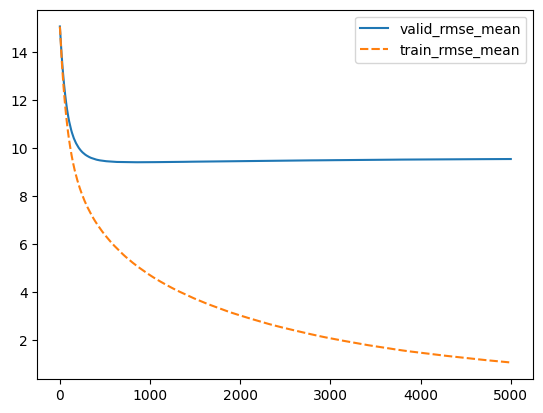

In [7]:
# plot cross-validated line
pltdat = pd.DataFrame({'valid_rmse_mean': cv['valid rmse-mean'], 'train_rmse_mean': cv['train rmse-mean']})
ax = sns.lineplot(data=pltdat)

In [8]:
params.update({'num_iterations': optimal_rounds})

bst = lgb.train(
    params=params,
    train_set=lgb_data_train,
)

In [9]:
# create final predictions
sbmssn_pred = bst.predict(df_to_predict)

In [10]:
# explain final model
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(dataset_x)

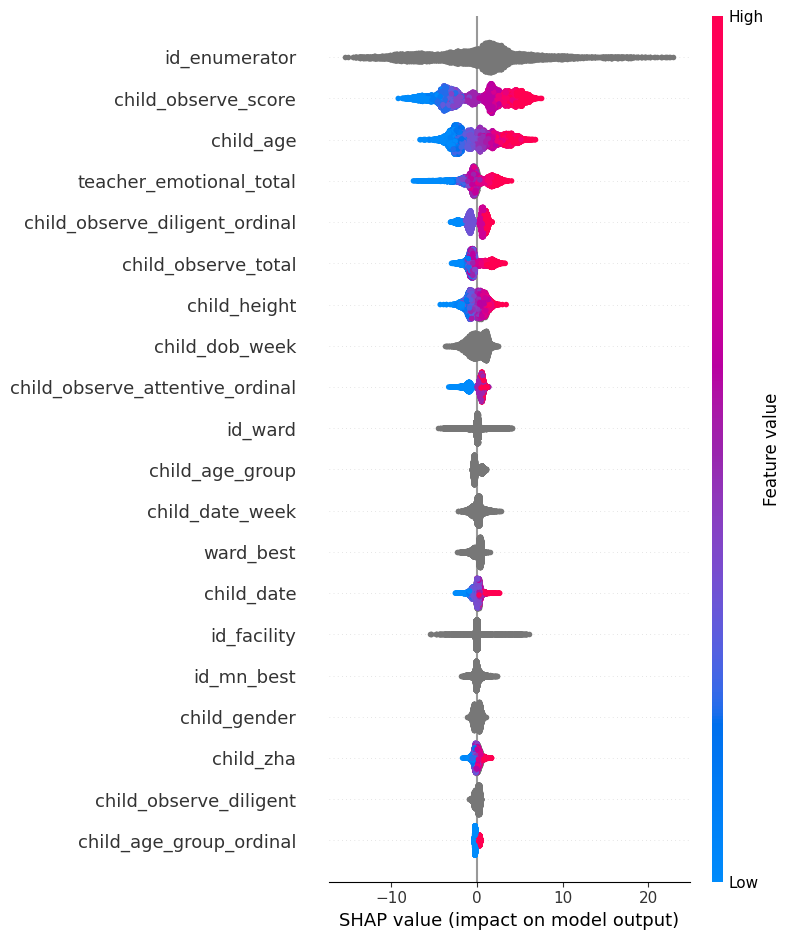

In [11]:
shap.summary_plot(shap_values, dataset_x)

In [12]:
# summarize the effects of all the features
# shap.plots.beeswarm(shap_values=shap_values)

In [13]:
ft = {
    'feature_1': [], 'feature_2': [], 'feature_3': [], 'feature_4': [], 'feature_5': [], 'feature_6': [], 'feature_7': [],
    'feature_8': [], 'feature_9': [], 'feature_10': [], 'feature_11': [], 'feature_12': [], 'feature_13': [], 'feature_14': [],
    'feature_15': []
}

shap_values = explainer.shap_values(df_to_predict)

for sv in shap_values: 
    arr = np.argsort(sv)[::-1][:15]
    for ind, a in enumerate(arr):
        place = f'feature_{ind+1}'
        ft[place].append(df_to_predict.columns[a])

final_sub = sbmssn.select('child_id')
final_sub = final_sub.with_columns(pl.Series(sbmssn_pred).alias('target'))

ft = pl.DataFrame(ft)
final_sub = pl.concat([final_sub, ft], how='horizontal')

fname = '../submission/' + time.strftime("%Y%m%d-%H%M%S") + '.csv'
final_sub.write_csv(fname)

In [14]:
# sensitivity analysis